# Interactive DermMNIST Demo (notebook prototype)

This interactive Jupyter notebook is a the single-file demo used while prototyping the codebase. It includes all code needed to run a minimal DermMNIST experiment cell-by-cell so you can debug and visualize intermediate outputs.

**Important caution (why we normally prefer the repo code):**
- Notebooks get long and hard to maintain as projects grow.
- Logic is harder to separate by concern; refactors are easier in modules.
- Version control diff noise is higher (JSON + outputs).
- Reproducibility and testing are better with scripts/configs.
- Many collaborators prefer code reviews on modules, not notebooks.

Use this notebook only for quick, minimal development. Once things work, move the logic into the structured `src/` codebase and YAML configs.


## How to use
- Run cells in order; edit the config dict if you want to change settings.
- You can execute cells one by one to debug and visualize intermediate plots.
- W&B logging is optional; disable in the config cell if you don't want it.
- Figures are shown inline and also saved under `./outputs` if enabled.


In [1]:
%matplotlib inline
import os, math, time, random, argparse
from typing import Dict, Any, Tuple, List, Optional

import yaml
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, roc_curve, auc, f1_score, accuracy_score

# Optional dependencies
try:
    import wandb
    _WANDB_AVAILABLE = True
except Exception:
    wandb = None
    _WANDB_AVAILABLE = False

try:
    import medmnist
    from medmnist import INFO
    _MEDMNIST_AVAILABLE = True
except Exception:
    medmnist = None
    INFO = None
    _MEDMNIST_AVAILABLE = False


## Config and utilities
This cell defines the default configuration and helper utilities for loading YAML overrides, seeding, and timestamping.


In [2]:
DEFAULT_CONFIG: Dict[str, Any] = {
    "seed": 42,
    "device": "cpu",  # keep CPU by default; user can set "cuda" if available
    "data": {
        "dataset": "dermamnist",
        "root": "./data",
        "download": True,
        "subset_train": 2000,
        "subset_val": 500,
        "num_workers": 0,
        "pin_memory": False,
        "image_size": 128,
    },
    "aug": {
        "aug_strength": "light",  # light | medium | chaos
        "hflip": True,
        "vflip": False,
        "rotation_deg": 10,
        "color_jitter": 0.05,
    },
    "model": {
        "backbone": "resnet18",
        "pretrained": True,
        "freeze_backbone": True,
        "dropout": 0.2,
    },
    "train": {
        "epochs": 2,
        "batch_size": 64,
        "lr": 1e-3,
        "weight_decay": 1e-4,
        "log_every_steps": 50,
    },
    "outputs": {
        "out_dir": "./outputs",
        "save_figures": True,
        "log_train_curves": True,
        "log_confusion_matrix": True,
        "log_roc_plot": True,
        "log_sample_images": True,
        "log_mistake_gallery": True,
        "n_samples_per_class": 2,
        "n_mistakes": 12,
    },
    "wandb": {
        "enabled": True,
        "mode": "online",  # online | offline | disabled
        "project": "mdai-dermamnist-demo",
        "entity": None,
        "run_name": None,
        "tags": ["session1", "workflow-demo"],
    },
}


def deep_update(base: Dict[str, Any], override: Dict[str, Any]) -> Dict[str, Any]:
    """Recursively update dict `base` with values from `override`."""
    out = dict(base)
    for k, v in override.items():
        if isinstance(v, dict) and isinstance(out.get(k), dict):
            out[k] = deep_update(out[k], v)
        else:
            out[k] = v
    return out


def load_config(path: Optional[str]) -> Dict[str, Any]:
    """Load YAML config and merge with defaults."""
    cfg = dict(DEFAULT_CONFIG)
    if path is None:
        return cfg
    with open(path, "r") as f:
        user_cfg = yaml.safe_load(f) or {}
    cfg = deep_update(cfg, user_cfg)
    return cfg


def set_seed(seed: int) -> None:
    """Best-effort reproducibility on CPU (and GPU if later enabled)."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def ensure_dir(path: str) -> None:
    os.makedirs(path, exist_ok=True)


def now_str() -> str:
    return time.strftime("%Y%m%d_%H%M%S")


## W&B helpers
Handles optional Weights & Biases setup and safe logging that no-ops when disabled.


In [3]:
def init_wandb(cfg: Dict[str, Any]):
    """Initialize W&B if enabled and available. Returns run or None."""
    wb = cfg.get("wandb", {})
    if not wb.get("enabled", True):
        return None
    if not _WANDB_AVAILABLE:
        print("[WARN] wandb not installed; continuing without W&B.")
        return None
    mode = wb.get("mode", "online")
    if mode == "disabled":
        return None

    wandb_kwargs = {
        "project": wb.get("project", "mdai-demo"),
        "name": wb.get("run_name", None),
        "tags": wb.get("tags", None),
        "config": cfg,
    }
    if wb.get("entity"):
        wandb_kwargs["entity"] = wb["entity"]
    if mode == "offline":
        os.environ["WANDB_MODE"] = "offline"

    run = wandb.init(**wandb_kwargs)
    return run


def wandb_log_safe(run, data: Dict[str, Any], step: Optional[int] = None) -> None:
    if run is None:
        return
    data = dict(data)
    data.pop("step", None)
    run.log(data, step=step)


## Dataset and transforms
Build preprocessing/augmentation pipelines and load DermMNIST. Uses MedMNIST; will prompt to install if missing.


In [4]:
def build_transforms(cfg: Dict[str, Any], train: bool) -> T.Compose:
    """Build preprocessing pipeline with optional augmentation strength."""
    img_size = int(cfg["data"]["image_size"])
    aug = cfg.get("aug", {})
    strength = aug.get("aug_strength", "light").lower()

    base = [
        T.Lambda(lambda img: img if isinstance(img, Image.Image) else T.ToPILImage()(img)),
        T.Resize((img_size, img_size)),
    ]

    if train:
        if strength == "light":
            rot = aug.get("rotation_deg", 10)
            jitter = aug.get("color_jitter", 0.05)
            p_h = 0.5 if aug.get("hflip", True) else 0.0
            p_v = 0.2 if aug.get("vflip", False) else 0.0
        elif strength == "medium":
            rot = max(15, aug.get("rotation_deg", 10))
            jitter = max(0.10, aug.get("color_jitter", 0.05))
            p_h = 0.5 if aug.get("hflip", True) else 0.0
            p_v = 0.3 if aug.get("vflip", False) else 0.0
        else:  # chaos
            rot = max(30, aug.get("rotation_deg", 10))
            jitter = max(0.25, aug.get("color_jitter", 0.05))
            p_h = 0.5
            p_v = 0.5

        if p_h > 0:
            base.append(T.RandomHorizontalFlip(p=p_h))
        if p_v > 0:
            base.append(T.RandomVerticalFlip(p=p_v))
        if rot > 0:
            base.append(T.RandomRotation(degrees=rot))
        if jitter and jitter > 0:
            base.append(T.ColorJitter(
                brightness=jitter, contrast=jitter, saturation=jitter, hue=min(0.1, jitter)
            ))

    base += [
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
    return T.Compose(base)


def load_dermamnist(cfg: Dict[str, Any]):
    """Download/load DermMNIST and return train_dataset, val_dataset, class_names."""
    if not _MEDMNIST_AVAILABLE:
        raise RuntimeError("medmnist is not installed. Install with: pip install medmnist")

    dataset_name = cfg["data"]["dataset"].lower()
    if dataset_name != "dermamnist":
        raise ValueError(f"This demo expects dermamnist, got: {dataset_name}")

    info = INFO[dataset_name]
    DataClass = getattr(medmnist, info["python_class"])
    class_names = [info["label"][str(i)] for i in range(len(info["label"]))]

    root = os.path.abspath(os.path.expanduser(cfg["data"]["root"]))
    ensure_dir(root)
    download = bool(cfg["data"].get("download", True))

    train_tf = build_transforms(cfg, train=True)
    val_tf = build_transforms(cfg, train=False)

    train_ds = DataClass(split="train", root=root, transform=train_tf, download=download)
    val_ds = DataClass(split="val", root=root, transform=val_tf, download=download)
    return train_ds, val_ds, class_names


def subset_dataset(ds, n: Optional[int], seed: int) -> torch.utils.data.Dataset:
    """Optionally subset a dataset to N examples with a shuffled index."""
    if n is None or n <= 0 or n >= len(ds):
        return ds
    rng = np.random.default_rng(seed)
    idx = np.arange(len(ds))
    rng.shuffle(idx)
    idx = idx[:n].tolist()
    return Subset(ds, idx)


def build_loaders(cfg: Dict[str, Any], train_ds, val_ds) -> Tuple[DataLoader, DataLoader]:
    bs = int(cfg["train"]["batch_size"])
    nw = int(cfg["data"]["num_workers"])
    pin = bool(cfg["data"]["pin_memory"])

    train_loader = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=nw, pin_memory=pin)
    val_loader = DataLoader(val_ds, batch_size=bs, shuffle=False, num_workers=nw, pin_memory=pin)
    return train_loader, val_loader


## Model
ResNet18 backbone with an optional frozen feature extractor and a small classifier head.


In [5]:
def build_model(cfg: Dict[str, Any], num_classes: int) -> nn.Module:
    """Create a ResNet18 classifier with optional frozen backbone."""
    mcfg = cfg.get("model", {})
    backbone_name = mcfg.get("backbone", "resnet18")
    pretrained = bool(mcfg.get("pretrained", True))
    freeze = bool(mcfg.get("freeze_backbone", True))
    dropout = float(mcfg.get("dropout", 0.2))

    if backbone_name != "resnet18":
        raise ValueError("This minimal demo implements resnet18 only.")

    weights = torchvision.models.ResNet18_Weights.DEFAULT if pretrained else None
    model = torchvision.models.resnet18(weights=weights)

    in_features = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout),
        nn.Linear(in_features, num_classes)
    )

    if freeze:
        for name, param in model.named_parameters():
            param.requires_grad = ("fc" in name)

    return model


def get_trainable_params(model: nn.Module) -> List[nn.Parameter]:
    return [p for p in model.parameters() if p.requires_grad]


## Training and evaluation helpers
Single-epoch training loop, evaluation, and basic multiclass metrics.


In [6]:
@torch.no_grad()
def softmax_probs(logits: torch.Tensor) -> torch.Tensor:
    return torch.softmax(logits, dim=1)


def train_one_epoch(
    model: nn.Module,
    loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    criterion: nn.Module,
    device: torch.device,
    log_every_steps: int,
    run=None,
    epoch: int = 0
) -> Tuple[float, float]:
    """Train for one epoch. Returns (avg_loss, avg_acc)."""
    model.train()
    total_loss = 0.0
    total_correct = 0
    total = 0

    for step, (x, y) in enumerate(loader):
        x = x.to(device)
        y = y.squeeze().long().to(device)

        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            preds = logits.argmax(dim=1)
            correct = (preds == y).sum().item()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_correct += correct
        total += bs

        if (step + 1) % log_every_steps == 0:
            wandb_log_safe(run, {
                "train/step_loss": loss.item(),
                "train/step_acc": correct / max(1, bs),
                "train/epoch": epoch,
            }, step=epoch * len(loader) + step)

    avg_loss = total_loss / max(1, total)
    avg_acc = total_correct / max(1, total)
    return avg_loss, avg_acc


@torch.no_grad()
def evaluate(
    model: nn.Module,
    loader: DataLoader,
    device: torch.device
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return y_true, y_pred, y_prob for the loader."""
    model.eval()
    ys, preds, probs = [], [], []

    for x, y in loader:
        x = x.to(device)
        y = y.squeeze().long()
        logits = model(x).cpu()
        p = softmax_probs(logits).numpy()
        pred = logits.argmax(dim=1).numpy()

        ys.append(y.numpy())
        preds.append(pred)
        probs.append(p)

    y_true = np.concatenate(ys, axis=0)
    y_pred = np.concatenate(preds, axis=0)
    y_prob = np.concatenate(probs, axis=0)
    return y_true, y_pred, y_prob


def compute_metrics_multiclass(y_true: np.ndarray, y_pred: np.ndarray, y_prob: np.ndarray) -> Dict[str, Any]:
    """Minimal multiclass metrics: accuracy, macro F1, per-class OvR AUC, macro AUC."""
    num_classes = y_prob.shape[1]
    acc = accuracy_score(y_true, y_pred)
    macro_f1 = f1_score(y_true, y_pred, average="macro")

    per_class_auc = {}
    aucs = []
    for c in range(num_classes):
        y_bin = (y_true == c).astype(int)
        if y_bin.sum() == 0 or y_bin.sum() == len(y_bin):
            per_class_auc[c] = float("nan")
            continue
        fpr, tpr, _ = roc_curve(y_bin, y_prob[:, c])
        a = auc(fpr, tpr)
        per_class_auc[c] = float(a)
        aucs.append(a)

    macro_auc = float(np.nanmean(list(per_class_auc.values()))) if len(per_class_auc) else float("nan")
    return {
        "accuracy": float(acc),
        "macro_f1": float(macro_f1),
        "macro_auc_ovr": float(macro_auc),
        "per_class_auc_ovr": per_class_auc,
    }


## Visualization utilities
Generate train curves, confusion matrix, ROC, sample grids, and mistake galleries. Figures are shown inline and can also be saved.


In [7]:
def fig_train_curves(history: Dict[str, List[float]]) -> plt.Figure:
    fig = plt.figure(figsize=(10, 4))
    ax1 = fig.add_subplot(1, 2, 1)
    ax2 = fig.add_subplot(1, 2, 2)

    ax1.plot(history["train_loss"], label="train_loss")
    ax1.plot(history["val_loss"], label="val_loss")
    ax1.set_title("Loss")
    ax1.set_xlabel("Epoch")
    ax1.legend()

    ax2.plot(history["train_acc"], label="train_acc")
    ax2.plot(history["val_acc"], label="val_acc")
    ax2.set_title("Accuracy")
    ax2.set_xlabel("Epoch")
    ax2.legend()

    fig.tight_layout()
    return fig


def fig_confusion_matrix(cm: np.ndarray, class_names: List[str]) -> plt.Figure:
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title("Confusion Matrix")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, rotation=45, ha="right")
    ax.set_yticklabels(class_names)

    thresh = cm.max() * 0.6 if cm.max() > 0 else 0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, str(cm[i, j]), ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black", fontsize=8)

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    fig.tight_layout()
    return fig


def fig_roc_ovr(y_true: np.ndarray, y_prob: np.ndarray, class_names: List[str]) -> plt.Figure:
    num_classes = y_prob.shape[1]
    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(1, 1, 1)
    ax.plot([0, 1], [0, 1], linestyle="--")

    aucs = []
    for c in range(num_classes):
        y_bin = (y_true == c).astype(int)
        if y_bin.sum() == 0 or y_bin.sum() == len(y_bin):
            continue
        fpr, tpr, _ = roc_curve(y_bin, y_prob[:, c])
        a = auc(fpr, tpr)
        aucs.append(a)
        ax.plot(fpr, tpr, label=f"{class_names[c]} (AUC={a:.2f})")

    macro_auc = np.mean(aucs) if len(aucs) else float("nan")
    ax.set_title(f"OvR ROC Curves (macro AUC={macro_auc:.2f})")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.legend(fontsize=8, loc="lower right")
    fig.tight_layout()
    return fig


def _unnormalize_img(x: torch.Tensor) -> torch.Tensor:
    mean = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
    std = torch.tensor([0.229, 0.224, 0.225])[:, None, None]
    x = x.detach().cpu()
    return torch.clamp(x * std + mean, 0.0, 1.0)


def fig_sample_images_by_class(dataset, class_names: List[str], n_per_class: int, max_classes: Optional[int] = None) -> plt.Figure:
    num_classes = len(class_names)
    if max_classes is not None:
        num_classes = min(num_classes, max_classes)

    per_class_idxs = {c: [] for c in range(num_classes)}
    for i in range(len(dataset)):
        _, y = dataset[i]
        c = int(y.squeeze().item()) if torch.is_tensor(y) else int(np.array(y).squeeze())
        if c in per_class_idxs and len(per_class_idxs[c]) < n_per_class:
            per_class_idxs[c].append(i)
        if all(len(per_class_idxs[c]) >= n_per_class for c in per_class_idxs):
            break

    rows = num_classes
    cols = n_per_class
    fig = plt.figure(figsize=(cols * 2.2, rows * 2.2))

    plot_idx = 1
    for c in range(num_classes):
        for j in range(n_per_class):
            ax = fig.add_subplot(rows, cols, plot_idx)
            plot_idx += 1
            if j >= len(per_class_idxs[c]):
                ax.axis("off")
                continue
            x, _ = dataset[per_class_idxs[c][j]]
            x_vis = _unnormalize_img(x)
            ax.imshow(np.transpose(x_vis.numpy(), (1, 2, 0)))
            ax.set_title(class_names[c], fontsize=9)
            ax.axis("off")

    fig.suptitle("Sample Images by Class (post-transform)", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.98])
    return fig


def fig_most_confident_wrong(x_batch: torch.Tensor, y_true: np.ndarray, y_pred: np.ndarray, y_prob: np.ndarray, class_names: List[str], n: int) -> plt.Figure:
    wrong = (y_true != y_pred)
    wrong_idxs = np.where(wrong)[0]
    if len(wrong_idxs) == 0:
        fig = plt.figure(figsize=(8, 3))
        ax = fig.add_subplot(1, 1, 1)
        ax.text(0.5, 0.5, "No wrong predictions found in the cached set.", ha="center", va="center", fontsize=12)
        ax.axis("off")
        fig.tight_layout()
        return fig

    conf = y_prob[np.arange(len(y_prob)), y_pred]
    wrong_conf = conf[wrong_idxs]
    top = wrong_idxs[np.argsort(-wrong_conf)][:n]

    cols = 3
    rows = int(math.ceil(len(top) / cols))
    fig = plt.figure(figsize=(cols * 2.2, rows * 2.2))

    for i, idx in enumerate(top):
        ax = fig.add_subplot(rows, cols, i + 1)
        x = _unnormalize_img(x_batch[idx])
        ax.imshow(np.transpose(x.numpy(), (1, 2, 0)))
        t = class_names[int(y_true[idx])]
        p = class_names[int(y_pred[idx])]
        c = conf[idx]
        ax.set_title(f"T:{t}\nP:{p} ({c:.2f})", fontsize=8)
        ax.axis("off")

    fig.suptitle("Most Confident Wrong Predictions", fontsize=14)
    fig.tight_layout(rect=[0, 0, 1, 0.95])
    return fig


def cache_validation_examples(model: nn.Module, loader: DataLoader, device: torch.device, max_images: int = 512):
    model.eval()
    xs, ys, preds, probs = [], [], [], []
    total = 0
    for x, y in loader:
        if total >= max_images:
            break
        x = x.to(device)
        y0 = y.squeeze().long().cpu().numpy()
        logits = model(x).cpu()
        p = softmax_probs(logits).numpy()
        pred = logits.argmax(dim=1).numpy()

        x_cpu = x.detach().cpu()
        xs.append(x_cpu)
        ys.append(y0)
        preds.append(pred)
        probs.append(p)
        total += x_cpu.shape[0]

    x_all = torch.cat(xs, dim=0)[:max_images]
    y_all = np.concatenate(ys, axis=0)[:max_images]
    pred_all = np.concatenate(preds, axis=0)[:max_images]
    prob_all = np.concatenate(probs, axis=0)[:max_images]
    return x_all, y_all, pred_all, prob_all


def save_fig(fig: plt.Figure, out_path: str) -> None:
    fig.savefig(out_path, dpi=200, bbox_inches="tight")
    plt.close(fig)


## Configure and run
Edit the config below if you want to tweak parameters. Then run the training cell to execute a full train/val cycle and display key plots/metrics inline. Figures are also saved under `./outputs` when enabled.


In [8]:
# You can override config values here (or set to None to use defaults)
CONFIG_PATH = None  # e.g., "configs/baseline.yaml" or None for defaults
cfg = load_config(CONFIG_PATH)
set_seed(int(cfg["seed"]))
ensure_dir(cfg["outputs"]["out_dir"])
print("Config loaded. Edit cfg in this cell if desired.")
cfg


Config loaded. Edit cfg in this cell if desired.


{'seed': 42,
 'device': 'cpu',
 'data': {'dataset': 'dermamnist',
  'root': './data',
  'download': True,
  'subset_train': 2000,
  'subset_val': 500,
  'num_workers': 0,
  'pin_memory': False,
  'image_size': 128},
 'aug': {'aug_strength': 'light',
  'hflip': True,
  'vflip': False,
  'rotation_deg': 10,
  'color_jitter': 0.05},
 'model': {'backbone': 'resnet18',
  'pretrained': True,
  'freeze_backbone': True,
  'dropout': 0.2},
 'train': {'epochs': 2,
  'batch_size': 64,
  'lr': 0.001,
  'weight_decay': 0.0001,
  'log_every_steps': 50},
 'outputs': {'out_dir': './outputs',
  'save_figures': True,
  'log_train_curves': True,
  'log_confusion_matrix': True,
  'log_roc_plot': True,
  'log_sample_images': True,
  'log_mistake_gallery': True,
  'n_samples_per_class': 2,
  'n_mistakes': 12},
 'wandb': {'enabled': True,
  'mode': 'online',
  'project': 'mdai-dermamnist-demo',
  'entity': None,
  'run_name': None,
  'tags': ['session1', 'workflow-demo']}}

In [9]:
def run_experiment(cfg: Dict[str, Any]):
    """Execute a full training + eval cycle based on the given config."""
    device = torch.device(cfg.get("device", "cpu"))
    if device.type == "cuda" and not torch.cuda.is_available():
        device = torch.device("cpu")
    print(f"[INFO] Using device: {device}")

    run = init_wandb(cfg)

    train_ds, val_ds, class_names = load_dermamnist(cfg)
    train_ds = subset_dataset(train_ds, int(cfg["data"]["subset_train"]), seed=int(cfg["seed"]))
    val_ds = subset_dataset(val_ds, int(cfg["data"]["subset_val"]), seed=int(cfg["seed"]) + 1)
    train_loader, val_loader = build_loaders(cfg, train_ds, val_ds)

    num_classes = len(class_names)
    print(f"[INFO] Classes ({num_classes}): {class_names}")
    print(f"[INFO] Train size: {len(train_ds)} | Val size: {len(val_ds)}")

    model = build_model(cfg, num_classes=num_classes).to(device)
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        get_trainable_params(model),
        lr=float(cfg["train"]["lr"]),
        weight_decay=float(cfg["train"]["weight_decay"]),
    )

    if cfg["outputs"].get("log_sample_images", True):
        try:
            fig = fig_sample_images_by_class(
                dataset=train_ds,
                class_names=class_names,
                n_per_class=int(cfg["outputs"]["n_samples_per_class"]),
            )
            plt.show()
            if cfg["outputs"].get("save_figures", True):
                save_fig(fig, os.path.join(cfg["outputs"]["out_dir"], f"samples_by_class_{now_str()}.png"))
            if run is not None:
                wandb_log_safe(run, {"viz/samples_by_class": wandb.Image(fig)}, step=0)
        except Exception as e:
            print(f"[WARN] Could not log sample images: {e}")

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    epochs = int(cfg["train"]["epochs"])
    log_every = int(cfg["train"]["log_every_steps"])

    print("Training started...")
    for epoch in range(epochs):
        t0 = time.time()
        train_loss, train_acc = train_one_epoch(
            model=model,
            loader=train_loader,
            optimizer=optimizer,
            criterion=criterion,
            device=device,
            log_every_steps=log_every,
            run=run,
            epoch=epoch,
        )

        model.eval()
        val_loss_sum = 0.0
        val_total = 0
        val_correct = 0
        with torch.no_grad():
            for x, y in val_loader:
                x = x.to(device)
                y = y.squeeze().long().to(device)
                logits = model(x)
                loss = criterion(logits, y)
                preds = logits.argmax(dim=1)
                val_correct += (preds == y).sum().item()
                bs = x.size(0)
                val_loss_sum += loss.item() * bs
                val_total += bs
        val_loss = val_loss_sum / max(1, val_total)
        val_acc = val_correct / max(1, val_total)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        elapsed = time.time() - t0
        print(f"[Epoch {epoch+1}/{epochs}] train_loss={train_loss:.4f} train_acc={train_acc:.4f} | val_loss={val_loss:.4f} val_acc={val_acc:.4f} | time={elapsed:.1f}s")

        wandb_log_safe(run, {
            "train/loss": train_loss,
            "train/accuracy": train_acc,
            "val/loss": val_loss,
            "val/accuracy": val_acc,
            "epoch": epoch,
        }, step=epoch)

    print("Evaluating final model on validation set...")
    y_true, y_pred, y_prob = evaluate(model, val_loader, device=device)
    metrics = compute_metrics_multiclass(y_true, y_pred, y_prob)
    print("[INFO] Final metrics:")
    print(f"  accuracy: {metrics['accuracy']:.4f}")
    print(f"  macro_f1:  {metrics['macro_f1']:.4f}")
    print(f"  macro_auc: {metrics['macro_auc_ovr']:.4f}")

    wandb_log_safe(run, {
        "metrics/accuracy": metrics["accuracy"],
        "metrics/macro_f1": metrics["macro_f1"],
        "metrics/macro_auc_ovr": metrics["macro_auc_ovr"],
    }, step=epochs)
    for c, a in metrics["per_class_auc_ovr"].items():
        name = class_names[int(c)]
        wandb_log_safe(run, {f"metrics/auc_ovr/{name}": a}, step=epochs)

    if cfg["outputs"].get("log_confusion_matrix", True):
        cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
        fig_cm = fig_confusion_matrix(cm, class_names)
        plt.show()
        if cfg["outputs"].get("save_figures", True):
            save_fig(fig_cm, os.path.join(cfg["outputs"]["out_dir"], f"confusion_matrix_{now_str()}.png"))
        if run is not None:
            wandb_log_safe(run, {"fig/confusion_matrix": wandb.Image(fig_cm)}, step=epochs)

    if cfg["outputs"].get("log_roc_plot", True):
        fig_roc = fig_roc_ovr(y_true, y_prob, class_names)
        plt.show()
        if cfg["outputs"].get("save_figures", True):
            save_fig(fig_roc, os.path.join(cfg["outputs"]["out_dir"], f"roc_ovr_{now_str()}.png"))
        if run is not None:
            wandb_log_safe(run, {"fig/roc_ovr": wandb.Image(fig_roc)}, step=epochs)

    if cfg["outputs"].get("log_train_curves", True):
        fig_curves = fig_train_curves(history)
        plt.show()
        if cfg["outputs"].get("save_figures", True):
            save_fig(fig_curves, os.path.join(cfg["outputs"]["out_dir"], f"train_curves_{now_str()}.png"))
        if run is not None:
            wandb_log_safe(run, {"fig/train_curves": wandb.Image(fig_curves)}, step=epochs)

    if cfg["outputs"].get("log_mistake_gallery", True):
        try:
            x_cache, y_cache, pred_cache, prob_cache = cache_validation_examples(
                model, val_loader, device=device, max_images=512
            )
            fig_wrong = fig_most_confident_wrong(
                x_batch=x_cache,
                y_true=y_cache,
                y_pred=pred_cache,
                y_prob=prob_cache,
                class_names=class_names,
                n=int(cfg["outputs"]["n_mistakes"]),
            )
            plt.show()
            if cfg["outputs"].get("save_figures", True):
                save_fig(fig_wrong, os.path.join(cfg["outputs"]["out_dir"], f"most_confident_wrong_{now_str()}.png"))
            if run is not None:
                wandb_log_safe(run, {"viz/most_confident_wrong": wandb.Image(fig_wrong)}, step=epochs)
        except Exception as e:
            print(f"[WARN] Could not create mistake gallery: {e}")

    if run is not None:
        run.finish()

    print(f"[DONE] Outputs saved to: {cfg['outputs']['out_dir']}")
    return metrics, history


## Run the demo
Execute the cell below to kick off training with the current config. Adjust `cfg` above if you want to change anything (e.g., fewer samples for speed).


[INFO] Using device: cpu


wandb: Currently logged in as: danfu42 to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Using downloaded and verified file: /Users/danfu/Research/AI Distinction/medical-ai-starter-kit/data/dermamnist.npz
Using downloaded and verified file: /Users/danfu/Research/AI Distinction/medical-ai-starter-kit/data/dermamnist.npz
[INFO] Classes (7): ['actinic keratoses and intraepithelial carcinoma', 'basal cell carcinoma', 'benign keratosis-like lesions', 'dermatofibroma', 'melanoma', 'melanocytic nevi', 'vascular lesions']
[INFO] Train size: 2000 | Val size: 500


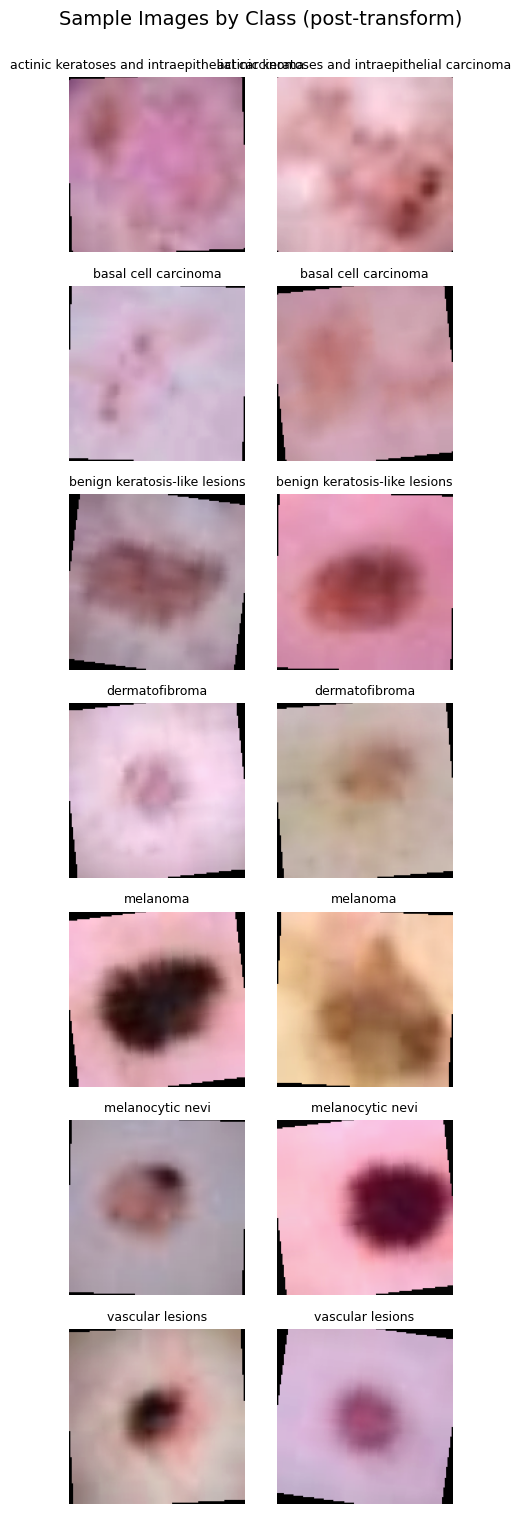

Training started...
[Epoch 1/2] train_loss=1.3027 train_acc=0.6245 | val_loss=1.0790 val_acc=0.7020 | time=22.3s
[Epoch 2/2] train_loss=0.9990 train_acc=0.6850 | val_loss=0.9713 val_acc=0.7180 | time=21.8s
Evaluating final model on validation set...
[INFO] Final metrics:
  accuracy: 0.7180
  macro_f1:  0.1848
  macro_auc: 0.7523


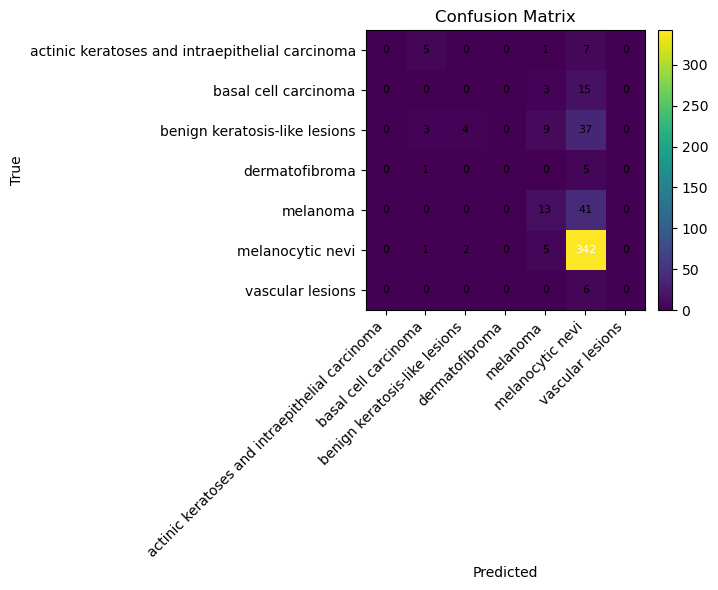

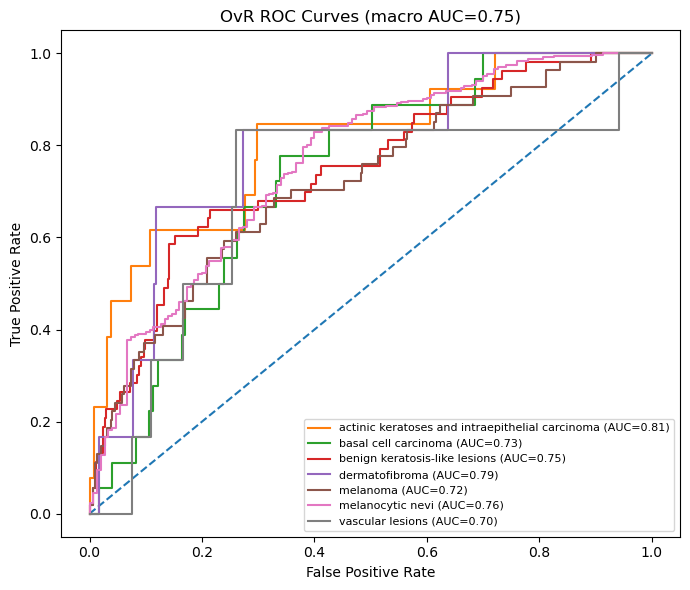

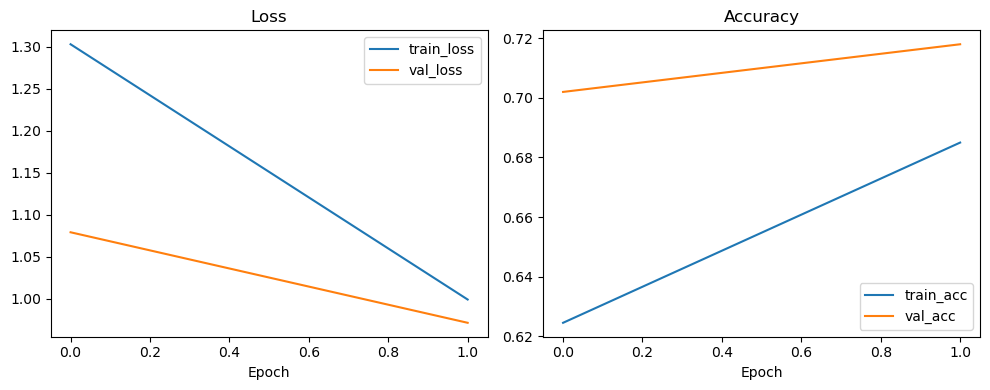

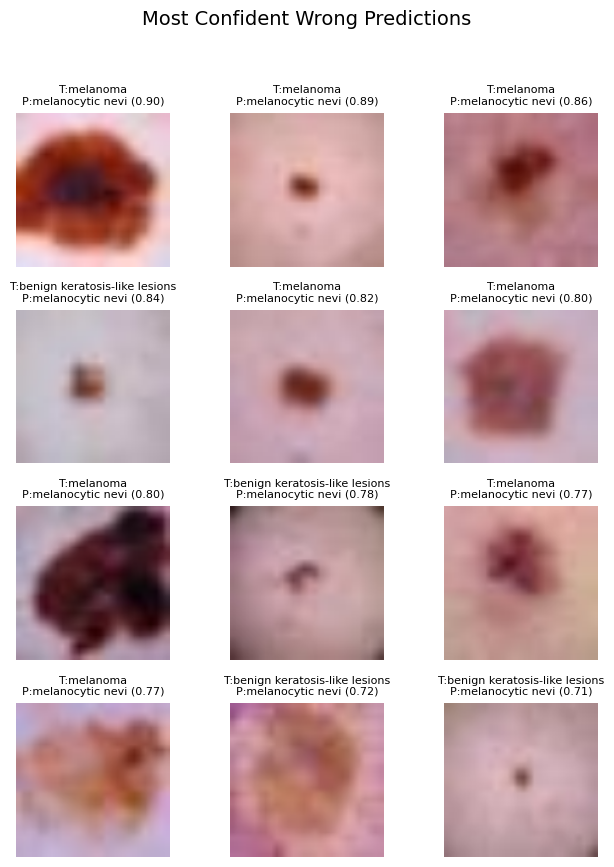

wandb: ERROR The nbformat package was not found. It is required to save notebook history.


epoch,▁█
metrics/accuracy,▁
metrics/auc_ovr/actinic keratoses and intraepithelial carcinoma,▁
metrics/auc_ovr/basal cell carcinoma,▁
metrics/auc_ovr/benign keratosis-like lesions,▁
metrics/auc_ovr/dermatofibroma,▁
metrics/auc_ovr/melanocytic nevi,▁
metrics/auc_ovr/melanoma,▁
metrics/auc_ovr/vascular lesions,▁
metrics/macro_auc_ovr,▁
+5,...


[DONE] Outputs saved to: ./outputs


{'accuracy': 0.718,
 'macro_f1': 0.18475447168545953,
 'macro_auc_ovr': 0.7522738625835524,
 'per_class_auc_ovr': {0: 0.8082451429474017,
  1: 0.7334024896265561,
  2: 0.7490608247857835,
  3: 0.793859649122807,
  4: 0.7198555057299453,
  5: 0.7624380952380951,
  6: 0.6990553306342779}}

In [10]:
metrics, history = run_experiment(cfg)
metrics
